### ***1. Import necessary libraries***
The cell below contains the code to import all the essential ilbraries I need to access for successful completion of my project.

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [3]:

from google.colab import drive
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.impute import SimpleImputer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers, models


/tmp/ipython-input-3293833073.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
# Mount Google Drive

drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Path to access dataset

session1 = "/content/drive/MyDrive/osfstorage-archive/1.0 Sessions"
demographics_file = r"/content/drive/MyDrive/osfstorage-archive/Demographic_Info.csv"

### ***2. Steps into Preprocessing***

In [7]:

# Join csv files
csv_files = glob.glob(os.path.join(session1, "*.csv"))
dataframes = []
for file in csv_files:
    df = pd.read_csv(file, encoding='utf-8-sig')                                # Read the CSV
    df.columns = df.columns.str.strip()                                         # Clean column names
    raw_name = os.path.splitext(os.path.basename(file))[0]
    child_id = raw_name.split('_Exported')[0]
    if 'Child ID' not in df.columns or df['Child ID'].isnull().all():           # Inject 'Child ID' into all rows if missing or all null
        df['Child ID'] = [child_id] * len(df)                                   # Assign to all rows
        print(f"Injected Child ID into: {os.path.basename(file)}")
    dataframes.append(df)                                                       # Append to list

# Combine all cleaned data
combined_df = pd.concat(dataframes, ignore_index=True, sort=False)


Injected Child ID into: ASLPLAY_21_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_18_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_22_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_19_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_24_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_23_Exported_05_31_24.csv
Injected Child ID into: ASLPLAY_17_Exported_05_31_24.csv


In [8]:

# Load demographics CSV
demographics = pd.read_csv(demographics_file)
demographics.columns = demographics.columns.str.strip()                         # Remove any space in header


In [9]:

# Merge combined_df with demographics
merged_data = pd.merge(combined_df, demographics, on='Child ID', how='left')
merged_data.to_csv(r"C:\Users\tiasa\Downloads\merged_data.csv", index=False)    # Save the merge file


In [10]:

# Dataset summary
print("Unique Child IDs:", sorted(merged_data['Child ID'].unique()))
print("Final merged dataset shape:", merged_data.shape)
print("Columns:", merged_data.columns)
print("First five rows:", merged_data.head())


Unique Child IDs: ['ASLPLAY_01', 'ASLPLAY_02', 'ASLPLAY_03', 'ASLPLAY_04', 'ASLPLAY_05', 'ASLPLAY_06', 'ASLPLAY_07', 'ASLPLAY_08', 'ASLPLAY_09', 'ASLPLAY_10', 'ASLPLAY_11', 'ASLPLAY_12', 'ASLPLAY_13', 'ASLPLAY_14', 'ASLPLAY_15', 'ASLPLAY_16', 'ASLPLAY_17', 'ASLPLAY_18', 'ASLPLAY_19', 'ASLPLAY_20', 'ASLPLAY_21', 'ASLPLAY_22', 'ASLPLAY_23', 'ASLPLAY_24']
Final merged dataset shape: (40265, 74)
Columns: Index(['Child ID', 'Begin Time - ss.msec', 'End Time - ss.msec',
       'Duration - ss.msec', 'Adult Attention Getting Strategies',
       'Adult1 ASL Dominant hand', 'Adult1 Dominant Hand append', 'Adult1 NMS',
       'Adult1 Non-Dominant Hand append', 'Adult1 Non-Dominant hand',
       'Adult1 free translation', 'Child ASL Dominant hand',
       'Child ASL Dominant hand append', 'Child ASL Non-Dominant hand',
       'Child Attention Getting Strategies', 'Child NMS',
       'Child Non-Dominant Hand append', 'Child Spoken English Transcription',
       'Child Spoken English append', 'Child

### ***3. Feature Engineering***
I have created the target variable as ASL_Score

In [11]:

# Selected Features to get ASL_Score
asl_columns = [
    'Child ASL Dominant hand',
    'Child ASL Non-Dominant hand',
    'Child ASL Dominant hand pho',
    'Child ASL Non-Dominant pho',
    'Child NMS',
    'Child ASL feedback',
    'Child free translation'
                ]
merged_data['ASL_Activity'] = merged_data[asl_columns].notna().sum(axis=1)      # Count non-null values across these columns per row
asl_scores = merged_data.groupby('Child ID')['ASL_Activity'].sum().reset_index()# Sum by Child ID
asl_scores = asl_scores.rename(columns={'ASL_Activity': 'ASL_Score'})
merged_data = pd.merge(merged_data, asl_scores, on='Child ID', how='left')
print(asl_scores.sort_values(by='ASL_Score', ascending=False))                  # Print ASL_Score


      Child ID  ASL_Score
20  ASLPLAY_21        365
22  ASLPLAY_23        251
21  ASLPLAY_22        210
15  ASLPLAY_16        189
23  ASLPLAY_24        168
5   ASLPLAY_06        137
18  ASLPLAY_19        113
14  ASLPLAY_15         97
19  ASLPLAY_20         78
17  ASLPLAY_18         60
12  ASLPLAY_13         59
2   ASLPLAY_03         58
16  ASLPLAY_17         54
11  ASLPLAY_12         47
7   ASLPLAY_08         44
6   ASLPLAY_07         37
13  ASLPLAY_14         36
9   ASLPLAY_10         23
1   ASLPLAY_02         20
10  ASLPLAY_11         17
3   ASLPLAY_04         12
8   ASLPLAY_09         12
4   ASLPLAY_05          0
0   ASLPLAY_01          0


### ***4. Exploratory Data Analysis (EDA)***
In this cell, I have visualized some important plots to explore the distribution of features and their relation with the target variable.

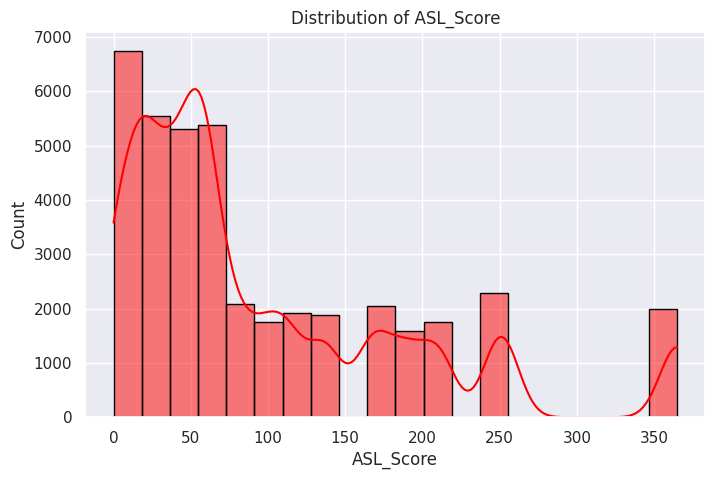

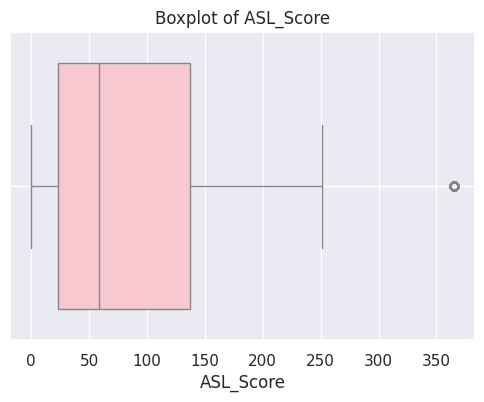

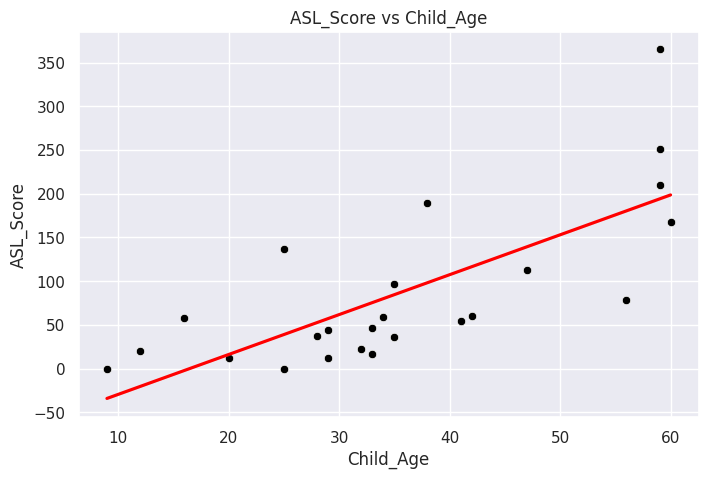

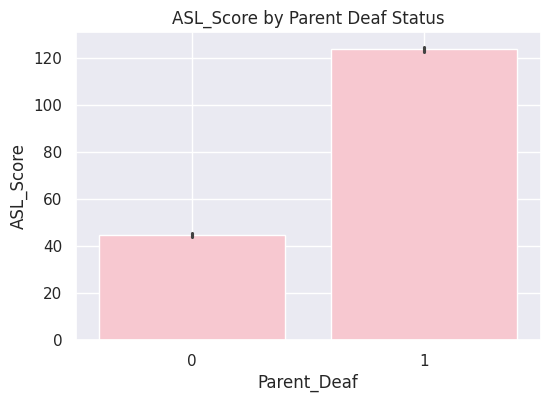

In [12]:

# Set up seaborn style
sns.set(style='dark', palette='pastel')

# Distribution of ASL_Score
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['ASL_Score'], kde=True, bins=20, color= "red", edgecolor="black")
plt.title("Distribution of ASL_Score")
plt.xlabel("ASL_Score")
plt.ylabel("Count")
plt.grid("dashed")
plt.savefig("Distribution_asl_score.jpg", dpi=300)

# Boxplot to check for outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=merged_data['ASL_Score'], color="pink")
plt.title("Boxplot of ASL_Score")
plt.xlabel("ASL_Score")
plt.grid("dashed")
plt.savefig("Boxplot.jpg", dpi=300)

# ASL_Score vs Child Age
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_data, x='Child_Age', y='ASL_Score', color="black")
sns.regplot(data=merged_data, x='Child_Age', y='ASL_Score', scatter=False, color='red')
plt.title("ASL_Score vs Child_Age")
plt.xlabel("Child_Age")
plt.ylabel("ASL_Score")
plt.grid("dashed")
plt.savefig("ASL_Score_vs_Child_Age.jpg", dpi=300)

# ASL_Score by Parent Deaf status
plt.figure(figsize=(6, 4))
sns.barplot(data=merged_data, x='Parent_Deaf', y='ASL_Score', color="pink")
plt.xlabel("Parent_Deaf")
plt.ylabel("ASL_Score")
plt.title("ASL_Score by Parent Deaf Status")
plt.grid("dashed")
plt.savefig("ASL_Score_by_Parent_Deaf.jpg", dpi=300)



In [13]:

# Final Features selection to train  the models
interaction_cols = [
    'EYE GAZE (adult)',
    'EYE GAZE (child)',
    'Object touch (adult) Left',
    'Object touch (adult) Right',
    'Object touch (child) Left',
    'Object touch (child) Right'
]
interaction_counts = merged_data.groupby('Child ID')[interaction_cols].apply(
                     lambda df: df.notnull().sum()).reset_index()               # count number of non-null entries per child per column
final_features = interaction_counts.merge(                                      # Merge with other features
                 merged_data[['Child ID', 'Child_Age', 'Parent_Deaf',
                 'Voice_Coded', 'ASL_Score']].drop_duplicates(),
                 on='Child ID',
                 how='left'
)
final_features


,Child ID,EYE GAZE (adult),EYE GAZE (child),Object touch (adult) Left,Object touch (adult) Right,Object touch (child) Left,Object touch (child) Right,Child_Age,Parent_Deaf,Voice_Coded,ASL_Score
0,ASLPLAY_01,407,319,109,138,69,67,9,0,1,0
1,ASLPLAY_02,425,298,82,92,68,75,12,0,1,20
2,ASLPLAY_03,369,281,127,114,45,42,16,0,1,58
3,ASLPLAY_04,133,116,10,13,20,20,20,0,1,12
4,ASLPLAY_05,340,372,141,96,149,159,25,1,1,0
5,ASLPLAY_06,459,395,43,149,78,82,25,1,0,137
6,ASLPLAY_07,409,230,89,107,113,65,28,1,0,37
7,ASLPLAY_08,402,288,45,104,71,73,29,1,0,44
8,ASLPLAY_09,310,232,63,51,65,60,29,0,1,12
9,ASLPLAY_10,687,478,67,88,127,145,32,0,1,23


## ***5. Regression Models***


In [14]:

# Define features and target
X = final_features.drop(columns=['Child ID', 'ASL_Score'])
y = final_features['ASL_Score']

# Split in train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Scaling the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression model
Lr_model = LinearRegression()
Lr_model.fit(X_train_scaled, y_train)
Lr_y_pred = Lr_model.predict(X_test_scaled)

# Evaluation
Lr_mae = mean_absolute_error(y_test, Lr_y_pred)
Lr_mse = mean_squared_error(y_test, Lr_y_pred)
Lr_rmse = np.sqrt(Lr_mse)
Lr_R2 = r2_score(y_test, Lr_y_pred)

print(f"Linear Regression MAE: {Lr_mae:.2f},MSE: {Lr_mse:.2f},RMSE: {Lr_rmse:.2f},R²: {Lr_R2:.2f}")

# Train Random Forest model
Rf_model = RandomForestRegressor(random_state=42)
Rf_model.fit(X_train, y_train)
Rf_y_pred = Rf_model.predict(X_test)

# Evaluation
Rf_mae = mean_absolute_error(y_test, Rf_y_pred)
Rf_mse = mean_squared_error(y_test, Rf_y_pred)
Rf_rmse = np.sqrt(Rf_mse)
Rf_R2 = r2_score(y_test, Rf_y_pred)

print(f"Random Forest MAE: {Rf_mae:.2f},MSE: {Rf_mse:.2f},RMSE: {Rf_rmse:.2f}, R²: {Rf_R2:.2f}")

Linear Regression MAE: 80.06,MSE: 9157.54,RMSE: 95.70,R²: -1.25
Random Forest MAE: 41.98,MSE: 2223.28,RMSE: 47.15, R²: 0.45


### ***6. Long Short-Term Memory Model***

In [15]:

# Load dataset
data_path = '/content/drive/MyDrive/merged_data.csv'
merged_data = pd.read_csv(data_path)

# Select features
feature_cols = [
    'EYE GAZE (adult)', 'EYE GAZE (child)',
    'Object touch (adult) Left', 'Object touch (adult) Right',
    'Object touch (child) Left', 'Object touch (child) Right',
    'Child_Age', 'Parent_Deaf', 'Voice_Coded'
]

data = merged_data[['Child ID'] + feature_cols + ['ASL_Activity']].copy()

# Clean and impute
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
imputer = SimpleImputer(strategy='constant', fill_value=0)
data[feature_cols] = imputer.fit_transform(data[feature_cols])

# Scale
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Group into sequences
sequence_data = []
sequence_targets = []

for _, group in data.groupby('Child ID'):
    X_seq = group[feature_cols].values
    y_seq = group['ASL_Activity'].values
    if len(X_seq) >= 10:
        sequence_data.append(X_seq)
        # Predict average ASL activity per child sequence
        sequence_targets.append(np.mean(y_seq))

# Pad X sequences (y is already 1D now)
X_padded = pad_sequences(sequence_data, padding='post', dtype='float32')
y_array = np.array(sequence_targets, dtype='float32')

# Train-test split
Lstm_X_train, Lstm_X_test, Lstm_y_train, Lstm_y_test = train_test_split(X_padded, y_array, test_size=0.2, random_state=42)

# LSTM model
Lstm_model = Sequential([
    Input(shape=(Lstm_X_train.shape[1], Lstm_X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

Lstm_model.compile(optimizer='adam', loss='mae', metrics=['mse'])

# LR scheduler
def scheduler(epoch, lr):
    return lr if epoch < 10 else float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)

# Train
history = Lstm_model.fit(
    Lstm_X_train, Lstm_y_train,
    validation_data=(Lstm_X_test, Lstm_y_test),
    epochs=30,
    batch_size=8,                                                               # increase batch size to 8
    callbacks=[lr_callback],
    verbose=1
)


/tmp/ipython-input-1751185262.py:3: DtypeWarning: Columns (7,14,17,26,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,65,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv(data_path)
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - loss: 0.0688 - mse: 0.0106 - val_loss: 0.0242 - val_mse: 8.0248e-04 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - loss: 0.0346 - mse: 0.0029 - val_loss: 0.0207 - val_mse: 5.1941e-04 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 0.0356 - mse: 0.0029 - val_loss: 0.0218 - val_mse: 7.0267e-04 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 0.0417 - mse: 0.0033 - val_loss: 0.0230 - val_mse: 8.8514e-04 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - loss: 0.0395 - mse: 0.0026 - val_loss: 0.0230 - val_mse: 8.9776e-04 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - loss: 0.0408 - mse: 0.0029 - val_loss: 0.0220 - val_mse: 7.2262e-04 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 377ms/step - loss: 0.0375 - mse: 0.0028 - val_loss: 0.0206 - val_mse: 5.7433e-04 - learning_rate:

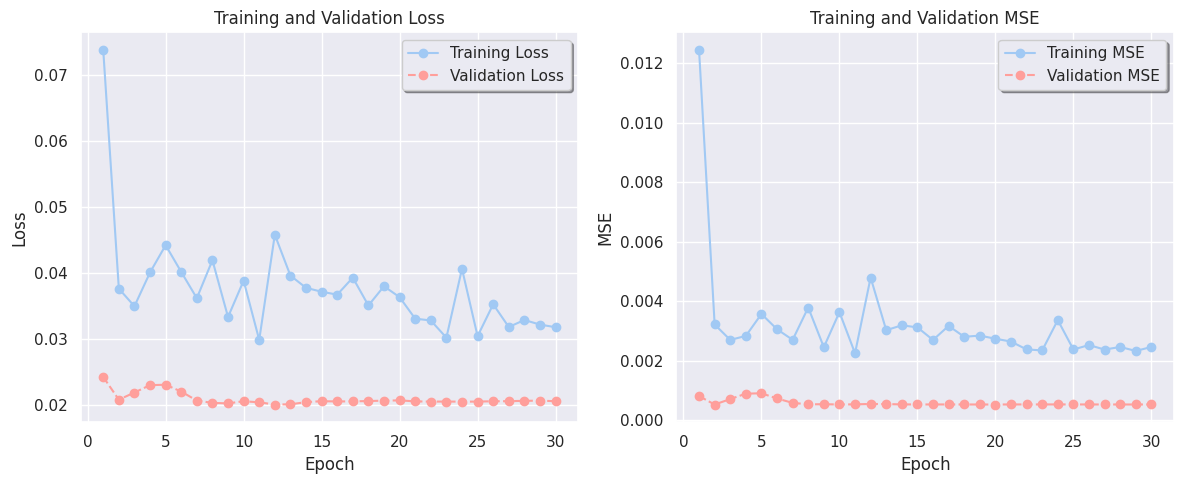

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract metrics
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    lr = history.history['learning_rate']
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(ticks=range(0, len(loss) + 1, 5))
    plt.grid("dashed")
    plt.legend(shadow=True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mse, 'bo-', label='Training MSE')
    plt.plot(epochs, val_mse, 'ro--', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.xticks(ticks=range(0, len(loss) + 1, 5))
    plt.grid("dashed")
    plt.legend(shadow=True)

    plt.tight_layout()
    plt.savefig("Loss-Metric.jpg", dpi=300)

# Usage
plot_training_history(history)


In [17]:

# Predict
Lstm_y_pred = Lstm_model.predict(Lstm_X_test).flatten()

# Test Metrics
Lstm_mae = mean_absolute_error(Lstm_y_test, Lstm_y_pred)
Lstm_mse = mean_squared_error(Lstm_y_test, Lstm_y_pred)
Lstm_rmse = np.sqrt(Lstm_mse)
Lstm_R2 = r2_score(Lstm_y_test, Lstm_y_pred)

print("Test Metrics:")
print(f"  MAE:  {Lstm_mae:.4f}")
print(f"  MSE:  {Lstm_mse:.4f}")
print(f"  RMSE: {Lstm_rmse:.4f}")
print(f"  R²:   {Lstm_R2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Test Metrics:
  MAE:  0.0205
  MSE:  0.0005
  RMSE: 0.0228
  R²:   -0.0045


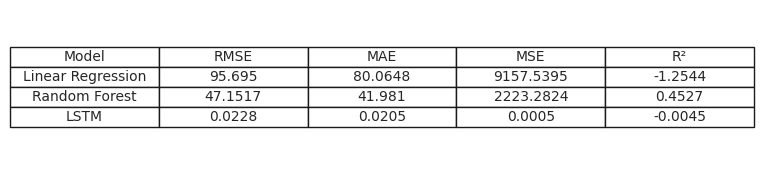

               Model     RMSE      MAE        MSE      R²
0  Linear Regression  95.6950  80.0648  9157.5395 -1.2544
1      Random Forest  47.1517  41.9810  2223.2824  0.4527
2               LSTM   0.0228   0.0205     0.0005 -0.0045


<Figure size 640x480 with 0 Axes>

In [18]:

# Build comparision table
metrics_data = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'RMSE': [Lr_rmse, Rf_rmse, Lstm_rmse],
    'MAE': [Lr_mae, Rf_mae, Lstm_mae],
    'MSE': [Lr_mse, Rf_mse, Lstm_mse],
    'R²': [Lr_R2, Rf_R2, Lstm_R2]
              }
df_metrics = pd.DataFrame(metrics_data)

# Display
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=df_metrics.round(4).values,
    colLabels=df_metrics.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()
plt.savefig("Comparison.jpg", dpi=300)

# Also print DataFrame for reference
print(df_metrics.round(4))


## ***7. Optimisation of the Models***
After building and evaluating the initial models, Now I have focused on optimizing their performance.

### **Handling Outliers and Re-applying Linear Regression**

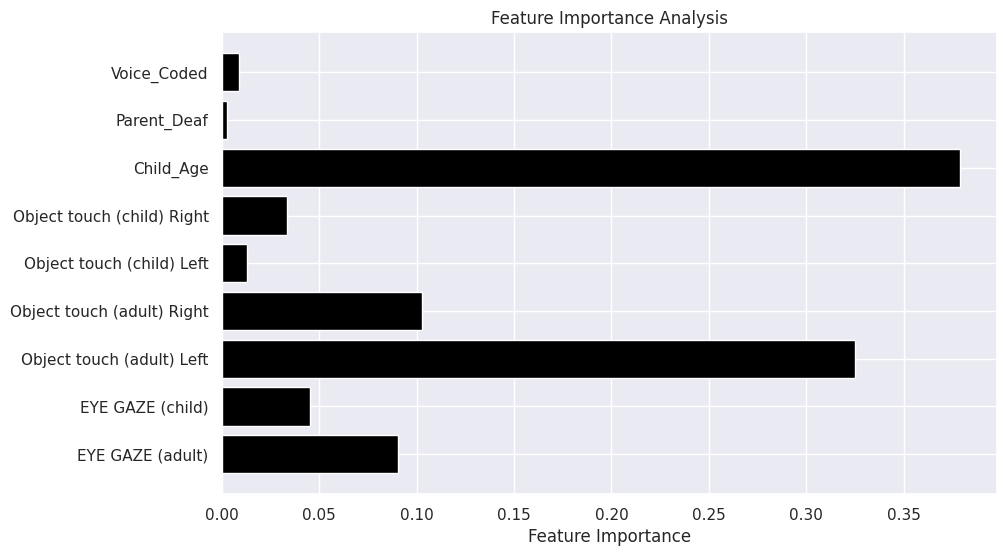


Random Forest Feature Importances
                      Feature  Importance
6                   Child_Age    0.378945
2   Object touch (adult) Left    0.325182
3  Object touch (adult) Right    0.102949
0            EYE GAZE (adult)    0.090385
1            EYE GAZE (child)    0.045105
5  Object touch (child) Right    0.033157
4   Object touch (child) Left    0.013082
8                 Voice_Coded    0.008855
7                 Parent_Deaf    0.002339

Selected Features: ['Child_Age', 'Object touch (adult) Left', 'Object touch (adult) Right', 'EYE GAZE (adult)']
Data shape before: (24, 11)
Data shape after outlier removal: (23, 11)

Linear Regression after Optimisation:
  MAE: 63.18
  MSE: 5472.15
  RMSE: 73.97
  R²:  -0.71


<Figure size 640x480 with 0 Axes>

In [19]:

# Get feature importance from Random Forest
importances = Rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))                                                     # Plot
plt.barh(features, importances, color="black")
plt.xlabel("Feature Importance")
plt.title("Feature Importance Analysis")
plt.grid("dashed")
plt.show()
plt.savefig("Feature-imp.jpg", dpi=300)

feature_importance_df = (                                                       # Create DataFrame
    pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    .sort_values(by='Importance', ascending=False)
)

print("\nRandom Forest Feature Importances")
print(feature_importance_df)

selected_features = feature_importance_df.loc[                                  # Select features above threshold
    feature_importance_df['Importance'] > 0.05, 'Feature'].tolist()
print(f"\nSelected Features: {selected_features}")

Q1, Q3 = final_features['ASL_Score'].quantile([0.25, 0.75])                     # Outlier Removal for Target (ASL_Score)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

final_features_filtered = final_features[
    final_features['ASL_Score'].between(lower, upper)].copy()

print(f"Data shape before: {final_features.shape}")
print(f"Data shape after outlier removal: {final_features_filtered.shape}")

X_filtered = final_features_filtered[selected_features]                         # Prepare Data
y_filtered = final_features_filtered['ASL_Score']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_filtered, y_filtered, test_size=0.4, random_state=42)                     # Split & scale

scaler = StandardScaler()
X_train_f = scaler.fit_transform(X_train_f)
X_test_f = scaler.transform(X_test_f)

Lr_op = LinearRegression()                                                    # Train & Evaluate Linear Regression
Lr_op.fit(X_train_f, y_train_f)
y_pred_f = Lr_op.predict(X_test_f)

Lr_op_mae = mean_absolute_error(y_test_f, y_pred_f)
Lr_op_mse = mean_squared_error(y_test_f, y_pred_f)
Lr_op_rmse = np.sqrt(Lr_op_mse)
Lr_op_R2 = r2_score(y_test_f, y_pred_f)

print(f"\nLinear Regression after Optimisation:")
print(f"  MAE: {Lr_op_mae:.2f}")
print(f"  MSE: {Lr_op_mse:.2f}")
print(f"  RMSE: {Lr_op_rmse:.2f}")
print(f"  R²:  {Lr_op_R2:.2f}")


### **Hyperparameter Tuning for Random Forest**

In [20]:

# Parameter Grid for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False] }

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(                # Data Split
    X, y, test_size=0.4, random_state=42)

rf = RandomForestRegressor(random_state=42)                                     # Random Forest & Randomized Search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,                                                                  # Lower for speed, higher for better search
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_rf, y_train_rf)                                       # Fit Model

print("\nBest Parameters:", random_search.best_params_)                         # Results
print("Best CV R² Score:", f"{random_search.best_score_:.4f}")

Rf_op = random_search.best_estimator_                                           # Evaluation on Test Set
y_pred_best_rf = Rf_op.predict(X_test_rf)

Rf_op_mae = mean_absolute_error(y_test_rf, y_pred_best_rf)
Rf_op_mse = mean_squared_error(y_test_rf, y_pred_best_rf)
Rf_op_rmse = np.sqrt(Rf_op_mse)
Rf_op_R2 = r2_score(y_test_rf, y_pred_best_rf)

print("\nRandom Forest after Optimisation:")
print(f"  MAE: {Rf_op_mae:.2f}")
print(f"  MSE: {Rf_op_mse:.2f}")
print(f"  RMSE: {Rf_op_rmse:.2f}")
print(f"  R²:  {Rf_op_R2:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best CV R² Score: -0.6617

Random Forest after Optimisation:
  MAE: 37.75
  MSE: 1916.13
  RMSE: 43.77
  R²:  0.53


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

### **Optimisation of LSTM**

In [21]:

data_path = '/content/drive/MyDrive/merged_data.csv'
merged_data = pd.read_csv(data_path)

# Feature columns
feature_cols = [
    'EYE GAZE (adult)', 'EYE GAZE (child)',
    'Object touch (adult) Left', 'Object touch (adult) Right',
    'Object touch (child) Left', 'Object touch (child) Right',
    'Child_Age', 'Parent_Deaf', 'Voice_Coded'
]

# Select features + target
data = merged_data[['Child ID'] + feature_cols + ['ASL_Activity']].copy()

# Clean numeric columns
for col in feature_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
data[feature_cols] = imputer.fit_transform(data[feature_cols])

# Scale features
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Convert to Sequence Data
sequence_data = []
sequence_targets = []
for _, group in data.groupby('Child ID'):
    X_seq = group[feature_cols].values
    y_seq = group['ASL_Activity'].values
    if len(X_seq) >= 10:
        sequence_data.append(X_seq)
        sequence_targets.append(np.mean(y_seq))

# Pad sequences
X_padded = pad_sequences(sequence_data, padding='post', dtype='float32')
y_array = np.array(sequence_targets, dtype='float32')

# Train-Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_padded, y_array, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

# Build LSTM Model Function for Tuning
def build_lstm_model(hp):
    model = models.Sequential()

    # Bidirectional LSTM
    model.add(
        layers.Bidirectional(
            layers.LSTM(
                units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
                dropout=hp.Float('lstm_dropout', 0.0, 0.5, step=0.1),
                recurrent_dropout=hp.Float('lstm_recurrent_dropout', 0.0, 0.5, step=0.1),
                return_sequences=False
            ),
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )

    # Dense hidden layer
    model.add(
        layers.Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
            activation='relu'
        )
    )
    # Output
    model.add(layers.Dense(1))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mse',
        metrics=['mae']
    )

    return model

# Set Up Random Search Tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='asl_play'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run Tuning
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[stop_early],
    batch_size=32)

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"LSTM Dropout: {best_hps.get('lstm_dropout')}")
print(f"LSTM Recurrent Dropout: {best_hps.get('lstm_recurrent_dropout')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Train Final Model with Best Hyperparameters
Lstm_op = tuner.hypermodel.build(best_hps)
history = Lstm_op.fit(
    X_train_full, y_train_full,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
    batch_size=32)

# Evaluate on Test Set
y_pred_best = Lstm_op.predict(X_test).flatten()

Lstm_op_mae = mean_absolute_error(y_test, y_pred_best)
Lstm_op_mse = mean_squared_error(y_test, y_pred_best)
Lstm_op_rmse = np.sqrt(Lstm_op_mse)
Lstm_op_R2 = r2_score(y_test, y_pred_best)

print("\nLSTM after Optimisation:")
print(f"  MAE: {Lstm_op_mae:.2f}")
print(f"  MSE: {Lstm_op_mse:.2f}")
print(f"  RMSE: {Lstm_op_rmse:.2f}")
print(f"  R²:  {Lstm_op_R2:.2f}")


Trial 5 Complete [00h 02m 58s]
val_mae: 0.026938755065202713

Best val_mae So Far: 0.026443442329764366
Total elapsed time: 00h 10m 13s

Best Hyperparameters:
LSTM Units: 96
LSTM Dropout: 0.0
LSTM Recurrent Dropout: 0.0
Dense Units: 16
Learning Rate: 0.0010210396790978165
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0060 - mae: 0.0618 - val_loss: 8.0503e-04 - val_mae: 0.0211
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - mae: 0.0327 - val_loss: 8.2814e-04 - val_mae: 0.0226
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0020 - mae: 0.0337 - val_loss: 9.8776e-04 - val_mae: 0.0239
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0018 - mae: 0.0299 - val_loss: 8.4491e-04 - val_mae: 0.0243
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0011 - mae: 0.0274 - val_loss: 4.9216e-04 - val_mae: 0.0185
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 9.2400e-04 - mae: 0.0242 - val_loss: 2.6418e-04 - val_mae: 0.0119
Epoch 7/20
1/1 ━━━━━━

  Trial ID  LSTM Units  Dropout  Rec. Dropout  Dense Units        LR  \
0        1          96      0.0           0.0           16  0.001021   
1        4         192      0.0           0.1           48  0.003606   
2        2         256      0.4           0.4          112  0.000421   
3        0         128      0.2           0.4          128  0.000116   
4        3          32      0.0           0.2           16  0.003331   

   Best Val MAE  Best Val Loss  
0      0.026443       0.001064  
1      0.026939       0.000915  
2      0.030312       0.001178  
3      0.039645       0.002384  
4      0.060545       0.004464  


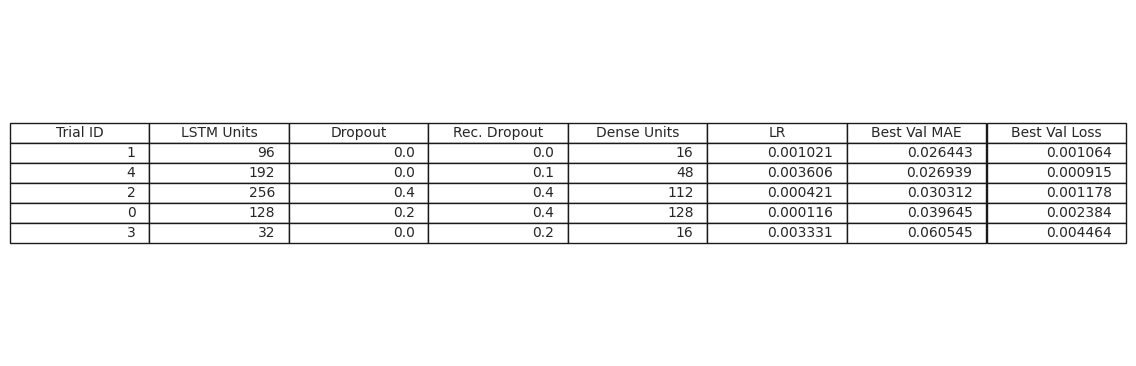

In [22]:
# Collect results for all trials without retraining
trial_results = []

for trial_id, trial in tuner.oracle.trials.items():
    hp = trial.hyperparameters.values
    trial_results.append({
        'Trial ID': trial_id,
        'LSTM Units': hp.get('lstm_units'),
        'Dropout': hp.get('lstm_dropout'),
        'Rec. Dropout': hp.get('lstm_recurrent_dropout'),
        'Dense Units': hp.get('dense_units'),
        'LR': hp.get('learning_rate'),
        'Best Val MAE': trial.metrics.get_best_value('val_mae'),
        'Best Val Loss': trial.metrics.get_best_value('val_loss')
    })

# Convert to DataFrame
results_df = pd.DataFrame(trial_results)

# Sort by Best Val MAE (lower is better)
results_df = results_df.sort_values(by='Best Val MAE').reset_index(drop=True)

# Round values for cleaner table
results_df = results_df.round(6)

# Print DataFrame
print(results_df)

# Plot the table
fig, ax = plt.subplots(figsize=(12, len(results_df) * 0.5 + 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()


### **Comparison of Model Performance (Before and After Optimization)**

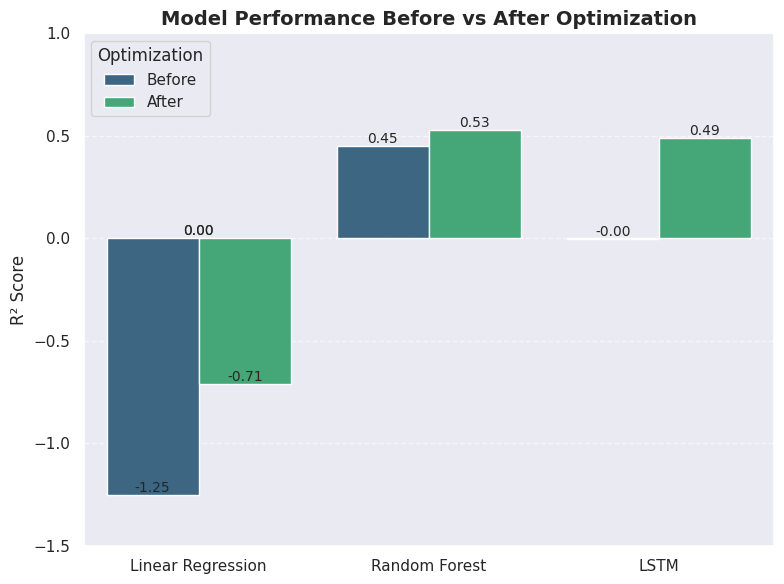

In [23]:

# R² scores
data = {
    'Model': ['Linear Regression', 'Linear Regression',
              'Random Forest', 'Random Forest',
              'LSTM', 'LSTM'],
    'Optimization': ['Before', 'After',
                     'Before', 'After',
                     'Before', 'After'],
    'R² Score': [Lr_R2, Lr_op_R2,
                 Rf_R2, Rf_op_R2,
                 Lstm_R2, Lstm_op_R2]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df,
    x='Model', y='R² Score', hue='Optimization',
    palette='viridis')

# Add score labels on bars
for p in plt.gca().patches:
    value = p.get_height()
    if pd.notnull(value):
        plt.gca().annotate(f"{value:.2f}",
                           (p.get_x() + p.get_width() / 2, value),
                           ha='center', va='bottom', fontsize=10)

plt.title('Model Performance Before vs After Optimization', fontsize=14, weight='bold')
plt.ylabel('R² Score')
plt.xlabel('')
plt.ylim(-1.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Optimization', loc='upper left')
plt.tight_layout()
plt.show()


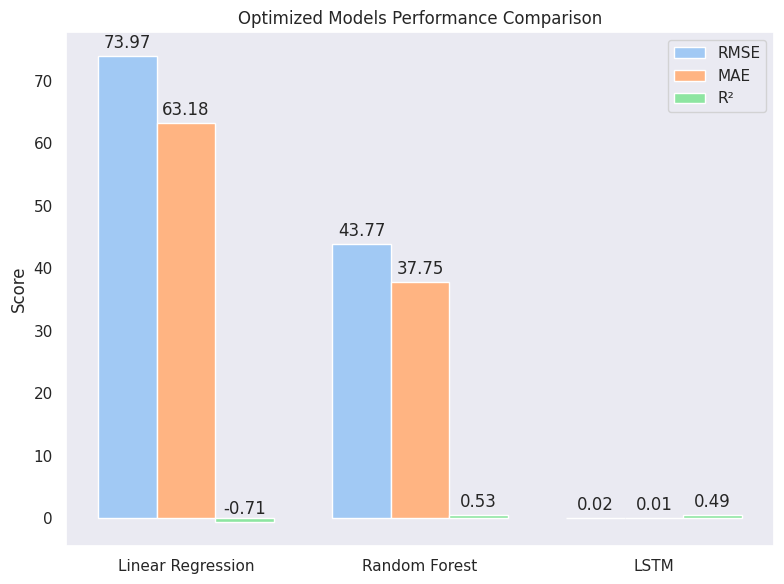

In [24]:

# Create dictionary directly from variables
model_scores = {
    "Linear Regression": (Lr_op_rmse, Lr_op_mae, Lr_op_R2),
    "Random Forest": (Rf_op_rmse, Rf_op_mae, Rf_op_R2),
    "LSTM": (Lstm_op_rmse, Lstm_op_mae, Lstm_op_R2) }

# Plotting
metrics = ["RMSE", "MAE", "R²"]
models = list(model_scores.keys())

rmse_values = [model_scores[m][0] for m in models]
mae_values  = [model_scores[m][1] for m in models]
r2_values   = [model_scores[m][2] for m in models]

x = np.arange(len(models))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - bar_width, rmse_values, width=bar_width, label='RMSE')
bars2 = ax.bar(x, mae_values, width=bar_width, label='MAE')
bars3 = ax.bar(x + bar_width, r2_values, width=bar_width, label='R²')

ax.set_ylabel('Score')
ax.set_title('Optimized Models Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate values
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


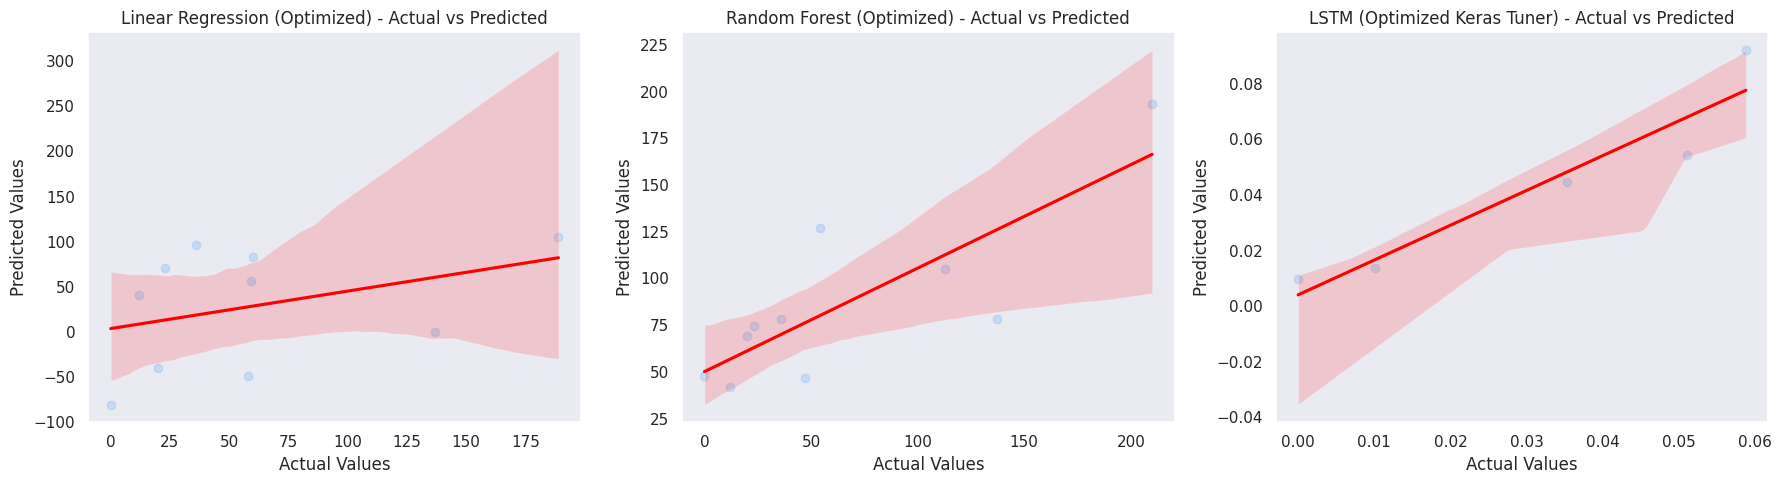

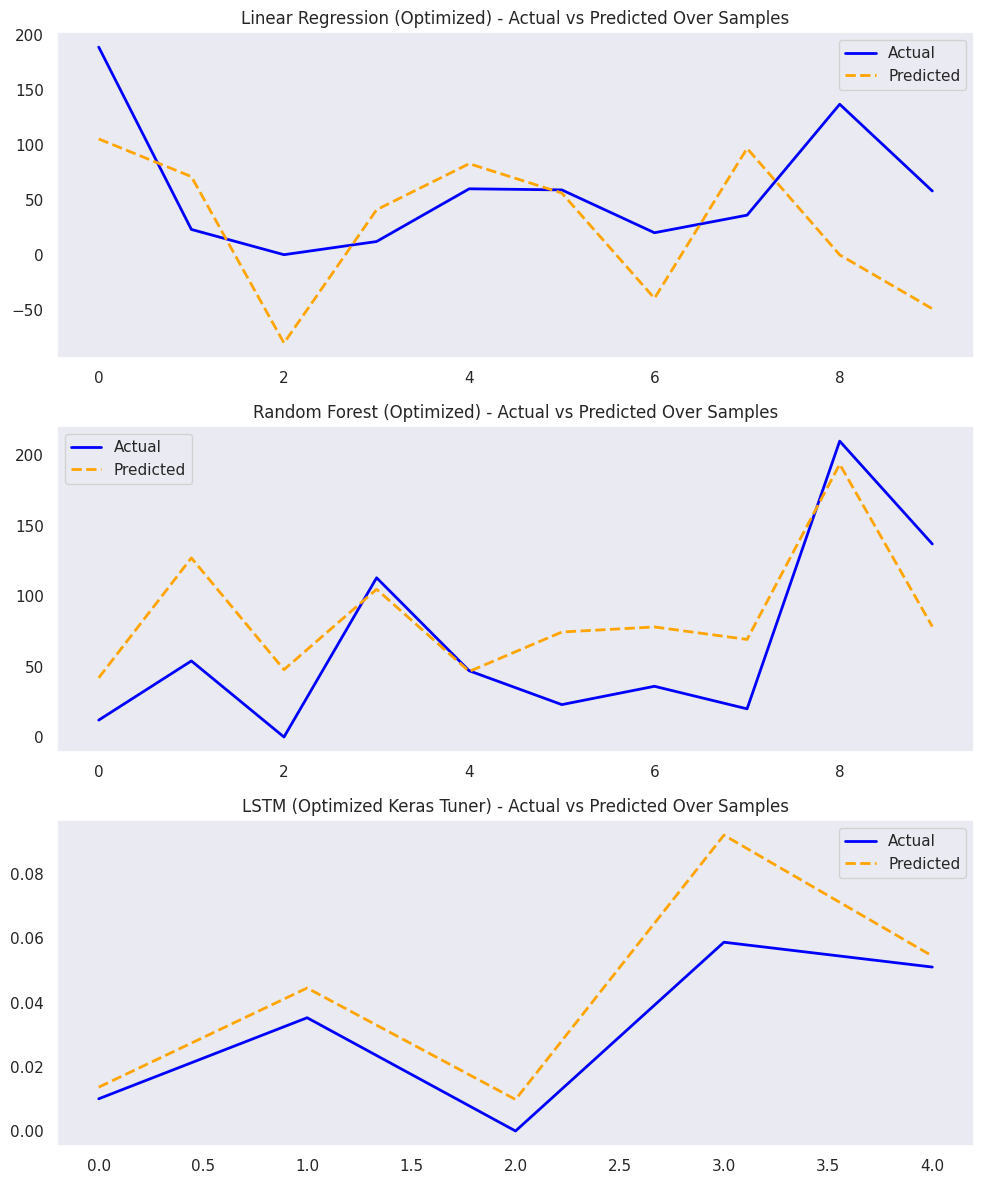

In [26]:

# Create a list of tuples, each containing the model name, actual test values, and predicted values
models_to_plot = [
    ("Linear Regression (Optimized)", y_test_f, y_pred_f),
    ("Random Forest (Optimized)", y_test_rf, y_pred_best_rf),
    ("LSTM (Optimized Keras Tuner)", y_test, y_pred_best) ]

# Correlation Scatter Plots (Actual vs Predicted)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model_name, y_actual, y_pred) in zip(axes, models_to_plot):
    sns.regplot(x=y_actual, y=y_pred, ax=ax, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    ax.set_title(f"{model_name} - Actual vs Predicted")
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
plt.tight_layout()
plt.show()

# Line Plots (Prediction vs Actual)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for ax, (model_name, y_actual, y_pred) in zip(axes, models_to_plot):
    ax.plot(y_actual.values if isinstance(y_actual, pd.Series) else y_actual, label="Actual", color='blue', linewidth=2)
    ax.plot(y_pred, label="Predicted", color='orange', linestyle='--', linewidth=2)
    ax.set_title(f"{model_name} - Actual vs Predicted Over Samples")
    ax.legend()
plt.tight_layout()
plt.show()